## 关于单独unit的可视化，需要另外进行x_test的重新“样本返回”，然后取对应的“id”进行预测就可以。
##  取任意id发动机进行单独可视化的代码暂时不公开，如果有需要的csdn私聊我，不刀，50元，科研不易，尊重劳动成果。最后感谢各位支持

In [76]:
%load_ext autoreload
%autoreload 2
# 需要在TF上跑的，可以在keras前添加tensorflow——from  tensorflow.keras.xxxx import xxxx
# from util.campss_diy import Model_to_save,Model_to_load
import os 
import sys

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('seaborn-whitegrid')#绘图的主题
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
#TF2.0以上的设置方法
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Setting seed for reproducibility
np.random.seed(1234)

# Input files don't have column names
dependent_var = ['RUL']#依赖的变量
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]#添加操作条件1,2,3,
sensor_measure_columns_names =["Sensor"+str(i) for i in range(1,22)]#添加传感器编号1，…，21
#输入发动机编号/运行时间/设置/哪个传感器数据/
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

## 读取训练集

In [3]:
input_file_column_names

['UnitNumber',
 'Cycle',
 'OpSet1',
 'OpSet2',
 'OpSet3',
 'Sensor1',
 'Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor5',
 'Sensor6',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor10',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor16',
 'Sensor17',
 'Sensor18',
 'Sensor19',
 'Sensor20',
 'Sensor21']

In [78]:
#pandas读取数据/True:以，为分割符/names:指定列名
df_train = pd.read_csv(r'F:\dataset\C-MAPSS\train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
df_train['RUL'] = df_train['max'] - df_train['Cycle']
#然后在把最大的max去掉
df_train.drop('max', axis=1, inplace=True)

In [7]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' 
df_train = pd.read_csv(r'F:\dataset\C-MAPSS\train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul1 = pd.DataFrame(df_train.groupby('UnitNumber'))
rul2 = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max())
rul3 = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
df_train.head()
rul1
rul2
rul3
print(rul1)
print(rul2)
print(rul3)

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,0,1
0,1,UnitNumber Cycle OpSet1 OpSet2 OpSet3...
1,2,UnitNumber Cycle OpSet1 OpSet2 OpSet3...
2,3,UnitNumber Cycle OpSet1 OpSet2 OpSet3...
3,4,UnitNumber Cycle OpSet1 OpSet2 OpSet3...
4,5,UnitNumber Cycle OpSet1 OpSet2 OpSet...
...,...,...
95,96,UnitNumber Cycle OpSet1 OpSet2 OpSe...
96,97,UnitNumber Cycle OpSet1 OpSet2 OpSe...
97,98,UnitNumber Cycle OpSet1 OpSet2 OpSe...
98,99,UnitNumber Cycle OpSet1 OpSet2 OpSe...


,Cycle
UnitNumber,
1,192
2,287
3,179
4,189
5,269
...,...
96,336
97,202
98,156


,UnitNumber,Cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


      0                                                  1
0     1       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3...
1     2       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3...
2     3       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3...
3     4       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3...
4     5        UnitNumber  Cycle  OpSet1  OpSet2  OpSet...
..  ...                                                ...
95   96         UnitNumber  Cycle  OpSet1  OpSet2  OpSe...
96   97         UnitNumber  Cycle  OpSet1  OpSet2  OpSe...
97   98         UnitNumber  Cycle  OpSet1  OpSet2  OpSe...
98   99         UnitNumber  Cycle  OpSet1  OpSet2  OpSe...
99  100         UnitNumber  Cycle  OpSet1  OpSet2  OpSe...

[100 rows x 2 columns]
            Cycle
UnitNumber       
1             192
2             287
3             179
4             189
5             269
...           ...
96            336
97            202
98            156
99            185
100           200

[100 rows x 1 columns]
    UnitNu

In [5]:
#https://www.jb51.net/article/155584.htm
#https://www.jb51.net/article/151614.htm

In [11]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Sensor10,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## 读取测试集

#### 方便可视化测试集，计算“截断的”RUL值：注意这里还不是Actual_RUL

In [79]:
df_test = pd.read_csv(r'F:\dataset\C-MAPSS\test_FD001.txt',delim_whitespace=True,names=input_file_column_names)
"""为了方便测试集的每一个unit的可视化，需要给测试集算出真实的RUL列值"""
rul = pd.DataFrame(df_test.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_test = df_test.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
"""此时还不是真实剩余RUL"""
df_test['RUL'] = df_test['max'] - df_test['Cycle']
#然后在把最大的max去掉
df_test.drop('max', axis=1, inplace=True)

df_test.head()

'为了方便测试集的每一个unit的可视化，需要给测试集算出真实的RUL列值'

'此时还不是真实剩余RUL'

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26


In [80]:
y_true = pd.read_csv('F:\dataset\C-MAPSS\RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
"""注意：这里UnitNumber=1=测试集的UnitNumber"""
y_true["UnitNumber"] = y_true.index+1
y_true

'注意：这里UnitNumber=1=测试集的UnitNumber'

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [81]:
"""首先制作以UnitNumber为ID的真是RUL的DataFrame"""
actual_rul = pd.DataFrame(y_true.groupby('UnitNumber')['RUL'].max()).reset_index()
actual_rul.columns = ['UnitNumber', 'acrul']
df_test = df_test.merge(actual_rul, on=['UnitNumber'], how='left')
df_test.head()

'首先制作以UnitNumber为ID的真是RUL的DataFrame'

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL,acrul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26,112


In [82]:
"""最终才是真实的测试集RUL"""
df_test['RUL'] = df_test['RUL']+df_test['acrul']
#然后在把最大的acrul去掉
df_test.drop('acrul', axis=1, inplace=True)

df_test

'最终才是真实的测试集RUL'

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [83]:
"""采用分段线性退化假说：参照相关的文献，其分段的RUL认为>=130的RUL值，均标记为RUL=130
    注意：部分文献的分段RUL=125
    github上面一般也没有这样处理的代码，但是论文都是用的120-130
"""
def fun(x):
    if x >= 125:
        return 125
    else:
        return x

'采用分段线性退化假说：参照相关的文献，其分段的RUL认为>=130的RUL值，均标记为RUL=130\n    注意：部分文献的分段RUL=125\n    github上面一般也没有这样处理的代码，但是论文都是用的120-130\n'

In [85]:
df_test['RUL']=df_test['RUL'].apply(lambda x: fun(x))
df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,125
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,125
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,125
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,125
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [84]:
y_true['RUL']=y_true['RUL'].apply(lambda x: fun(x))
y_true

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,125,96
96,82,97
97,59,98
98,117,99


## 数据分析

In [14]:
df_train.isnull().sum()

UnitNumber    0
Cycle         0
OpSet1        0
OpSet2        0
OpSet3        0
Sensor1       0
Sensor2       0
Sensor3       0
Sensor4       0
Sensor5       0
Sensor6       0
Sensor7       0
Sensor8       0
Sensor9       0
Sensor10      0
Sensor11      0
Sensor12      0
Sensor13      0
Sensor14      0
Sensor15      0
Sensor16      0
Sensor17      0
Sensor18      0
Sensor19      0
Sensor20      0
Sensor21      0
RUL           0
dtype: int64

## 绘制小提琴图

Text(0.5, 1.0, 'Life of Engines')

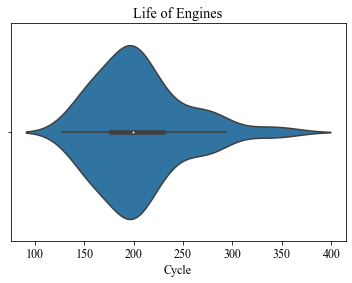

In [12]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
sns.violinplot(temp_df.Cycle)
plt.title("Life of Engines")
temp_df
# plt.xticks(fontsize=12, fontweight='bold')  # 默认字体大小为10

Text(0.5, 1.0, 'Life of Engines')

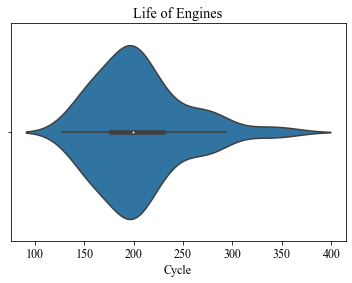

In [13]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
sns.violinplot(temp_df.Cycle)
plt.title("Life of Engines")
# plt.xticks(fontsize=12, fontweight='bold')  # 默认字体大小为10

In [8]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
temp_df

,Cycle
UnitNumber,
1,192
2,287
3,179
4,189
5,269
...,...
96,336
97,202
98,156


## 拥有最大RUL的排序首位五个

## 拥有最大RUL的排序，末尾的五个

## 三个工况的操作条件可视化，选择其中一个单元

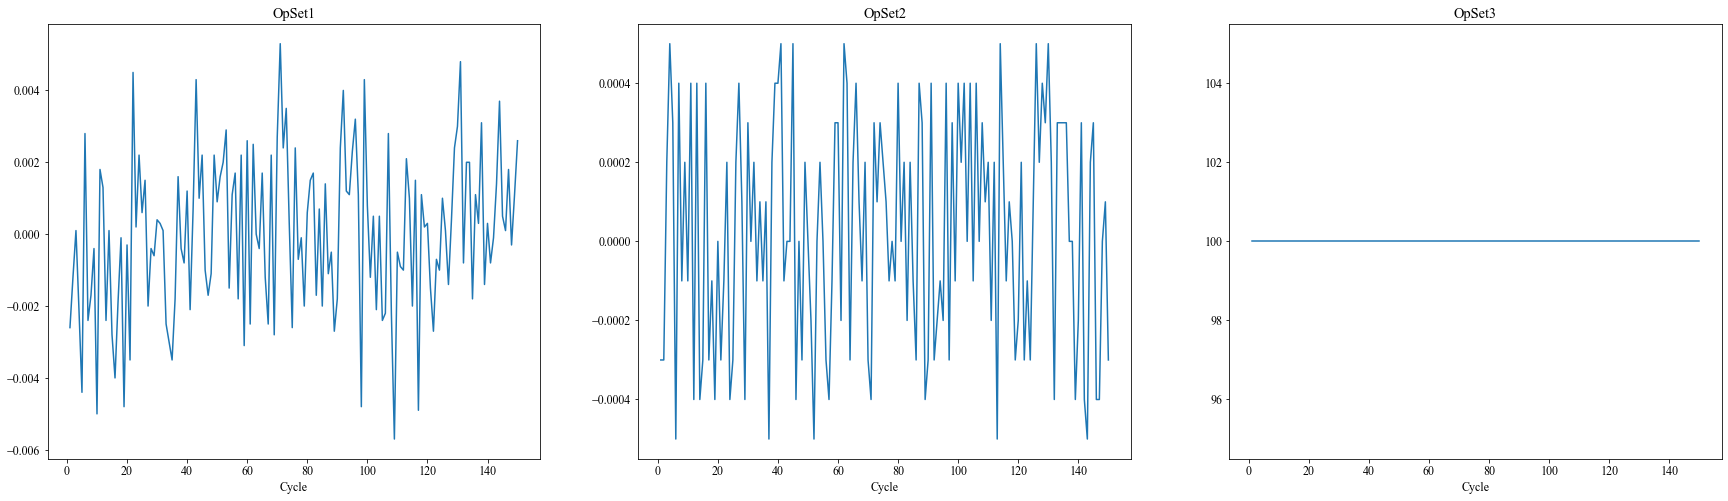

In [7]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==8')
    ax[i].plot(df_u1.Cycle.values, df_u1['OpSet'+str(i+1)])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

## 选择其中一个单元进行传感器数据的可视化

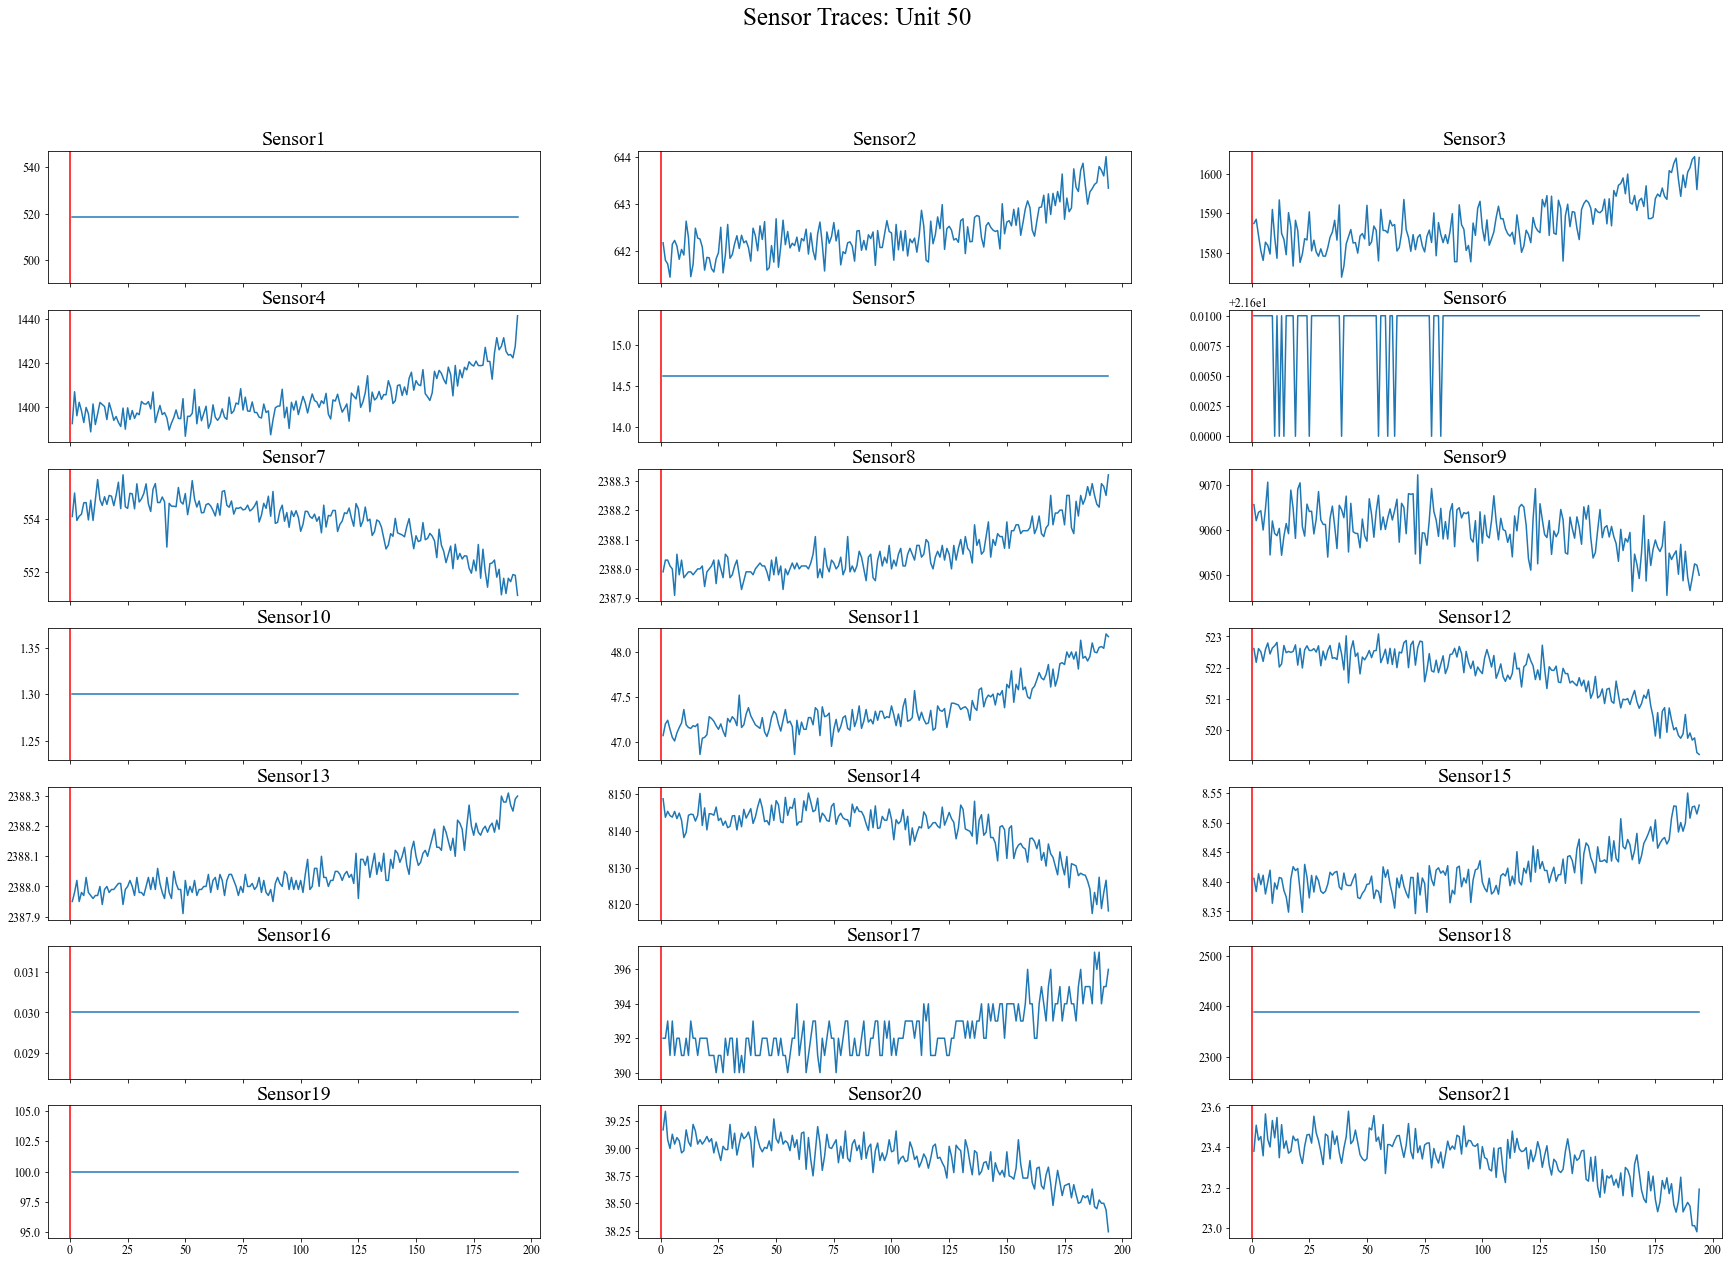

In [9]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==30')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['Sensor'+str(c+1)])
        ax[i,j].set_title('Sensor'+str(c+1),fontsize=20)
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 50',fontsize=25)
plt.show()

### 去除没必要的传单其数据

In [86]:
# necessary features for analysis

"""FD001&FD003"""
not_required_feats = ["Sensor1", "Sensor5", "Sensor6", "Sensor10", "Sensor16", "Sensor18", "Sensor19"]

# """FD002"""
# not_required_feats = []


feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

'FD001&FD003'

['Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21']

In [12]:
feats + ["RUL"]

['Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21',
 'RUL']

### 进行相关性分析

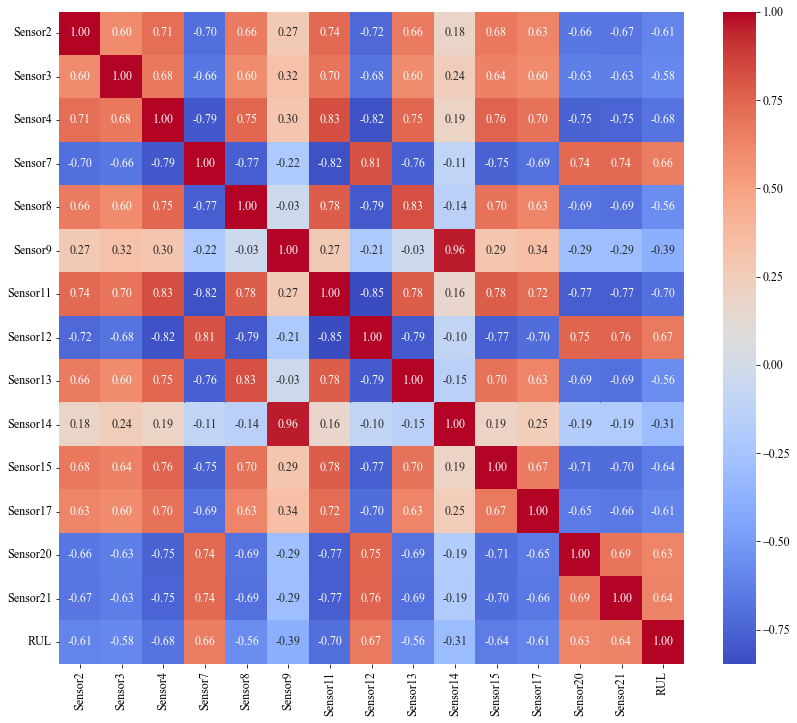

In [13]:
corr = df_train[feats + ["RUL"]].corr()

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")

### 可视化在失效之前，传感器的数值

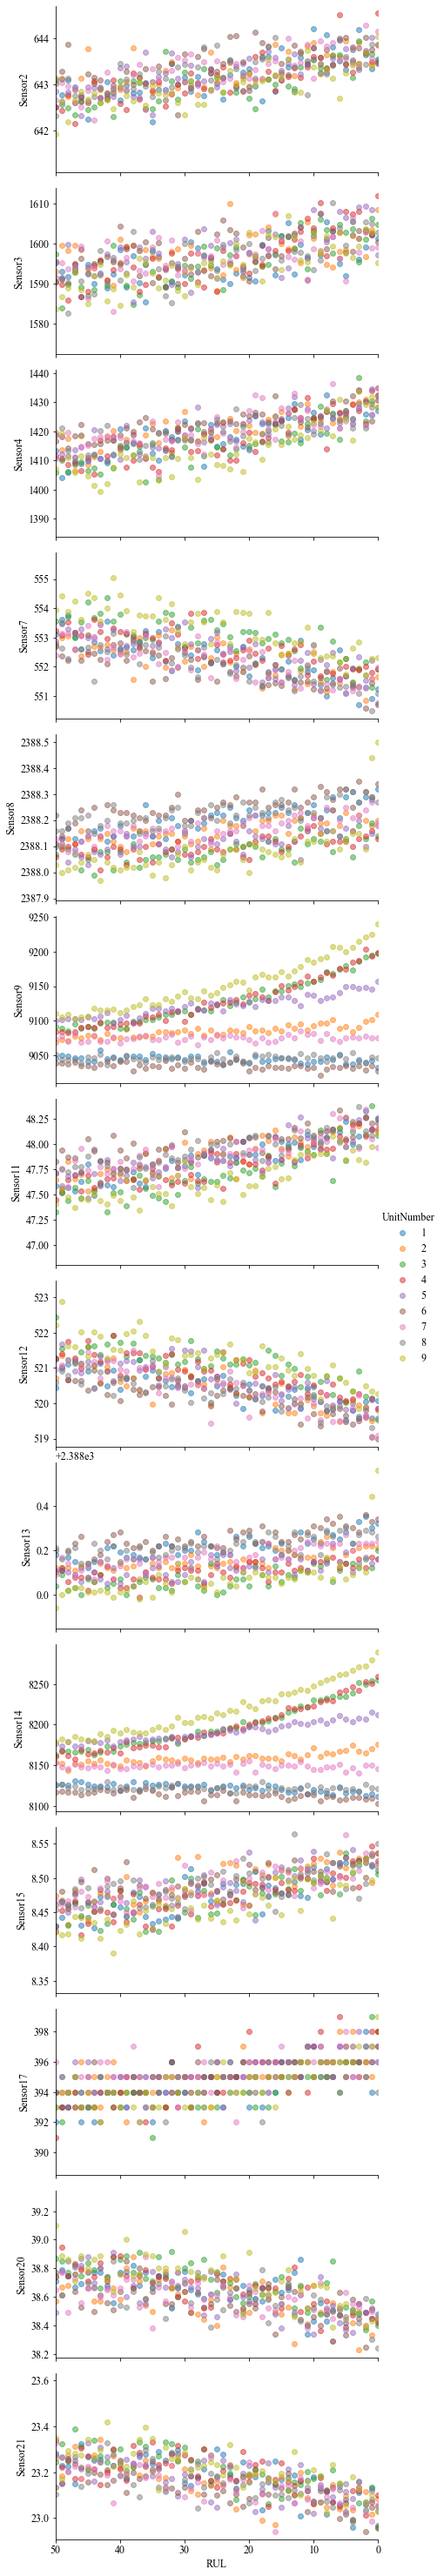

In [14]:
pairPlot = sns.PairGrid(data = df_train[df_train.UnitNumber < 10], x_vars = "RUL", y_vars = feats, hue = "UnitNumber", size = 3, aspect = 2)
pairPlot = pairPlot.map(plt.scatter, alpha = 0.5)
pairPlot = pairPlot.set(xlim = (50, 0))
pairPlot = pairPlot.add_legend()

### 查看两个传感器之间的相关性

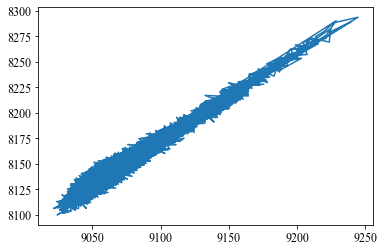

In [15]:
plt.plot(df_train.Sensor9, df_train.Sensor14)

## 二.数据处理

为了确保特征的方差保持在相同的范围内，缩放特征是很重要的。如果一个特征的方差大于其他特征的方差的数量级，则该特定特征可能支配数据集中的其他特征，这是不可取的。

In [87]:
sequence_length = 36
mask_value = 0
"""选择哪些特征进行预测"""
# feats.append('Cycle')
# feats=feats+operational_settings_columns_names

'选择哪些特征进行预测'

In [88]:
#这里是否出现问题/ MinMaxScaler：归一到 [ 0，1 ] MaxAbsScaler：归一到 [ -1，1 ] 
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])


### 自定义数据的三维转换函数

In [89]:
# LSTM希望输入是三维numpy数组的形状，我需要相应地转换训练和测试数据。
def gen_train(id_df, seq_length, seq_cols):
 
    data_array = id_df[seq_cols].values
    #存储的array的shape,第一个维度必须是0，有且仅有这一个，代表这个维度是可拓展的。
    num_elements = data_array.shape[0]    # 样本数量
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)
    

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]


def gen_test(id_df, seq_length, seq_cols, mask_value):
    print(id_df.head())
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    print(df_mask.head())
    df_mask[:] = mask_value
    print(df_mask.head())
    id_df = df_mask.append(id_df,ignore_index=True)
    print(id_df.head())
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [60]:
gen_target(df_train[df_train['UnitNumber']==1], sequence_length, "RUL")

array([156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144,
       143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131,
       130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118,
       117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105,
       104, 103, 102, 101, 100,  99,  98,  97,  96,  95,  94,  93,  92,
        91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,  80,  79,
        78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,  66,
        65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,
        52,  51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,
        39,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,
        26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,
        13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,
         0], dtype=int64)

In [53]:
x = gen_train(df_train[df_train['UnitNumber']==1], sequence_length, feats)
x.shape
df_train[df_train['UnitNumber']==1].shape
print(type (x))
print(type (list(x)))
print(type (list(list(x))))
list(list(x))

(157, 36, 14)

(192, 26)

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>


[array([[6.41820e+02, 1.58970e+03, 1.40060e+03, 5.54360e+02, 2.38806e+03,
         9.04619e+03, 4.74700e+01, 5.21660e+02, 2.38802e+03, 8.13862e+03,
         8.41950e+00, 3.92000e+02, 3.90600e+01, 2.34190e+01],
        [6.42150e+02, 1.59182e+03, 1.40314e+03, 5.53750e+02, 2.38804e+03,
         9.04407e+03, 4.74900e+01, 5.22280e+02, 2.38807e+03, 8.13149e+03,
         8.43180e+00, 3.92000e+02, 3.90000e+01, 2.34236e+01],
        [6.42350e+02, 1.58799e+03, 1.40420e+03, 5.54260e+02, 2.38808e+03,
         9.05294e+03, 4.72700e+01, 5.22420e+02, 2.38803e+03, 8.13323e+03,
         8.41780e+00, 3.90000e+02, 3.89500e+01, 2.33442e+01],
        [6.42350e+02, 1.58279e+03, 1.40187e+03, 5.54450e+02, 2.38811e+03,
         9.04948e+03, 4.71300e+01, 5.22860e+02, 2.38808e+03, 8.13383e+03,
         8.36820e+00, 3.92000e+02, 3.88800e+01, 2.33739e+01],
        [6.42370e+02, 1.58285e+03, 1.40622e+03, 5.54000e+02, 2.38806e+03,
         9.05515e+03, 4.72800e+01, 5.22190e+02, 2.38804e+03, 8.13380e+03,
         8.4

In [90]:
#generate train
# feats 为使用的传感器编号
# sequence_length 设置为36
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) 
                            for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17131, 36, 14)


In [91]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) 
                              for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17131,)

In [67]:
'''def gen_test(id_df, seq_length, seq_cols, mask_value):
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)'''

df_test.head()
df_test['UnitNumber'].unique()

'def gen_test(id_df, seq_length, seq_cols, mask_value):\n    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)\n    df_mask[:] = mask_value\n    \n    id_df = df_mask.append(id_df,ignore_index=True)\n    \n    data_array = id_df[seq_cols].values\n    num_elements = data_array.shape[0]\n    lstm_array=[]\n\n    start = num_elements-seq_length\n    stop = num_elements\n    \n    lstm_array.append(data_array[start:stop, :])\n    \n    return np.array(lstm_array)'

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,125
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,125
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,125
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,125
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,125


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [92]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)
x_test

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
0           1      1  0.0023  0.0003   100.0   518.67  0.545181  0.310661   
1           1      2 -0.0027 -0.0003   100.0   518.67  0.150602  0.379551   
2           1      3  0.0003  0.0001   100.0   518.67  0.376506  0.346632   
3           1      4  0.0042  0.0000   100.0   518.67  0.370482  0.285154   
4           1      5  0.0014  0.0000   100.0   518.67  0.391566  0.352082   

    Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0  0.269413    14.62  ...  0.220588  0.132160  0.308965      0.03  0.333333   
1  0.222316    14.62  ...  0.264706  0.204768  0.213159      0.03  0.416667   
2  0.322248    14.62  ...  0.220588  0.155640  0.458638      0.03  0.416667   
3  0.408001    14.62  ...  0.250000  0.170090  0.257022      0.03  0.250000   
4  0.332039    14.62  ...  0.220588  0.152751  0.300885      0.03  0.166667   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0      2388  

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

      UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
1171          12      1 -0.0015 -0.0001   100.0   518.67  0.250000  0.422934   
1172          12      2 -0.0002  0.0002   100.0   518.67  0.304217  0.357750   
1173          12      3  0.0007  0.0002   100.0   518.67  0.201807  0.137781   
1174          12      4 -0.0031  0.0004   100.0   518.67  0.322289  0.327229   
1175          12      5  0.0002 -0.0002   100.0   518.67  0.222892  0.339438   

       Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  \
1171  0.298447    14.62  ...  0.147059  0.207968  0.315506      0.03   
1172  0.321236    14.62  ...  0.205882  0.177882  0.205079      0.03   
1173  0.203747    14.62  ...  0.176471  0.205542  0.253174      0.03   
1174  0.347232    14.62  ...  0.220588  0.167613  0.290112      0.03   
1175  0.187036    14.62  ...  0.205882  0.203323  0.310119      0.03   

      Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  RUL  
1171  0.416667      2388

      UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
1983          18      1  0.0007 -0.0004   100.0   518.67  0.307229  0.345760   
1984          18      2 -0.0041 -0.0004   100.0   518.67  0.424699  0.116852   
1985          18      3  0.0030 -0.0002   100.0   518.67  0.277108  0.192719   
1986          18      4 -0.0048  0.0004   100.0   518.67  0.219880  0.317201   
1987          18      5 -0.0014  0.0003   100.0   518.67  0.337349  0.252235   

       Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  \
1983  0.218433    14.62  ...  0.235294  0.253845  0.340516      0.03   
1984  0.345881    14.62  ...  0.088235  0.208897  0.283186      0.03   
1985  0.362930    14.62  ...  0.117647  0.212664  0.202386      0.03   
1986  0.283761    14.62  ...  0.279412  0.238157  0.217391      0.03   
1987  0.333727    14.62  ...  0.250000  0.260708  0.388611      0.03   

      Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  RUL  
1983  0.416667      2388

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

[5 rows x 27 columns]
      UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
3360          29      1 -0.0003  0.0005   100.0   518.67  0.234940  0.208633   
3361          29      2 -0.0038 -0.0004   100.0   518.67  0.256024  0.214083   
3362          29      3 -0.0008 -0.0003   100.0   518.67  0.159639  0.290604   
3363          29      4  0.0016  0.0004   100.0   518.67  0.346386  0.451057   
3364          29      5 -0.0039  0.0002   100.0   518.67  0.421687  0.192283   

       Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  \
3360  0.375928    14.62  ...  0.279412  0.182165  0.309735      0.03   
3361  0.372046    14.62  ...  0.264706  0.171638  0.169296      0.03   
3362  0.280047    14.62  ...  0.117647  0.168645  0.218546      0.03   
3363  0.397873    14.62  ...  0.191176  0.200898  0.437091      0.03   
3364  0.340817    14.62  ...  0.235294  0.171225  0.227010      0.03   

      Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  RUL  
33

[5 rows x 27 columns]
   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0.0       0.0       0.0

[5 rows x 27 columns]
   UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1  Sensor2  Sensor3  \
0         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
1         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
2         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
3         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   
4         0.0    0.0     0.0     0.0     0.0      0.0      0.0      0.0   

   Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  Sensor17  \
0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
1      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
3      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0   

   Sensor18  Sensor19  Sensor20  Sensor21  RUL  
0       0

       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
11983          93      1  0.0021 -0.0001   100.0   518.67  0.370482  0.465664   
11984          93      2  0.0020 -0.0002   100.0   518.67  0.340361  0.447351   
11985          93      3 -0.0003  0.0003   100.0   518.67  0.518072  0.470024   
11986          93      4 -0.0023  0.0004   100.0   518.67  0.295181  0.485503   
11987          93      5  0.0019 -0.0005   100.0   518.67  0.334337  0.330935   

        Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  \
11983  0.361242    14.62  ...  0.279412  0.192073  0.474028      0.03   
11984  0.493417    14.62  ...  0.279412  0.187687  0.441324      0.03   
11985  0.503545    14.62  ...  0.279412  0.200433  0.603309      0.03   
11986  0.504727    14.62  ...  0.279412  0.214109  0.410543      0.03   
11987  0.297434    14.62  ...  0.367647  0.219063  0.502886      0.03   

       Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  RUL  
11983  0.25

       UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  Sensor1   Sensor2   Sensor3  \
12801          99      1  0.0007 -0.0004   100.0   518.67  0.259036  0.405058   
12802          99      2 -0.0021  0.0001   100.0   518.67  0.560241  0.308917   
12803          99      3  0.0028  0.0005   100.0   518.67  0.213855  0.192501   
12804          99      4 -0.0026 -0.0005   100.0   518.67  0.231928  0.040767   
12805          99      5 -0.0046  0.0003   100.0   518.67  0.234940  0.144757   

        Sensor4  Sensor5  ...  Sensor13  Sensor14  Sensor15  Sensor16  \
12801  0.108035    14.62  ...  0.117647  0.221591  0.116583      0.03   
12802  0.151249    14.62  ...  0.220588  0.246930  0.284725      0.03   
12803  0.215733    14.62  ...  0.161765  0.225255  0.228165      0.03   
12804  0.172350    14.62  ...  0.205882  0.226804  0.230473      0.03   
12805  0.168130    14.62  ...  0.176471  0.240634  0.172759      0.03   

       Sensor17  Sensor18  Sensor19  Sensor20  Sensor21  RUL  
12801  0.33

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.22289157, 0.35120994, 0.26772451, ..., 0.33333333,
         0.68217054, 0.64609224],
        [0.47590361, 0.32003488, 0.3160027 , ..., 0.25      ,
         0.73643411, 0.7079536 ],
        [0.4126506 , 0.22193155, 0.2812289 , ..., 0.41666667,
         0.51937984, 0.63656448]],

       [[0.37650602, 0.40505777, 0.34402431, ..., 0.41666667,
         0.6124031 , 0.6264844 ],
        [0.3373494 , 0.24220624, 0.27802161, ..., 0.5       ,
         0.56589147, 0.68876001],
        [0.40060241, 0.38042293, 0.32427414, ..., 0.41666667,
         0.55813953, 0.64457332],
        ...,
        [0.4939759 , 0.36058426, 0.3541526 , ..., 0.33333333,
         0.57364341, 0.55550953],
        [0.4

In [93]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [94]:
# import keras.backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error

#自定义评价指标
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

#自定义PHM2008评价函数
def Scoring_2008(Y_true, Y_pred):
    h = Y_pred - Y_true
    g = (-(h-K.abs(h))/2.0)  # 正数为0
    f = ((K.abs(h)+h)/2.0)   # 负数取0
    return K.sum(K.exp(g/13.0)-1)+K.sum(K.exp(f/10.0)-1)

In [103]:
input_shape = (4, 10, 128)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape=input_shape[1:])(x)
print(y.shape)
print(input_shape[1:])

(4, 8, 32)
(10, 128)


In [105]:
inputt=Input(shape=(x_train.shape[1],x_train.shape[2]))
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(inputt)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=3,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(100,activation='tanh')(x)
x = tf.keras.layers.Dense(1,activation='relu')(x)

DCNN_model=Model(inputs=inputt,outputs=x)
#查看网络结构
DCNN_model.summary()
#编译模型 RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
"""分段学习率"""
def scheduler(epoch):
    if epoch > 200:
        return 0.0001
    else:
        return 0.001
"""打印学习率，方便查看"""
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr#无衰减策略的学习率
    return lr

optimizer_diy =tf.keras.optimizers.Adam(learning_rate=0.001)
lr_metric = get_lr_metric(optimizer_diy)

DCNN_model.compile(optimizer=optimizer_diy,loss='mse',metrics=['mse','mae',RMSE,Scoring_2008,lr_metric]) 


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 36, 14)]          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 36, 10)            1410      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 36, 10)            1010      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 36, 10)            1010      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 36, 10)            1010      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 36, 10)            310       
_________________________________________________________________
flatten_4 (Flatten)          (None, 360)              

'分段学习率'

'打印学习率，方便查看'

In [106]:
%%time
#训练模型
# """https://blog.csdn.net//article/details/106398881
#     连续保存模型参数model_{epoch:03d}.hdf5；join(save_dir, 'model_Weights_{epoch:03d}.h5')
# """NewComerSyt:period=1,

Batch_size=512
save_dir="../DCNN_复现/FD001_30time/"
if not os.path.exists(save_dir):
                os.makedirs(save_dir)
"""
注意：validation_data=(x_test,y_test)这样是不允许的，算是训练作弊
要么是通过手动从x_train中单独划分(x_vaild,y_vaild),raise后采用validation_data=(x_vaild,y_vaild)
要么通过keras或者tf.keras中的model.fit(validation_split=0.1-0.3)从训练集随机划分
"""
History = DCNN_model.fit(x_train, y_train, epochs=250, batch_size=Batch_size,validation_split=0.20,
                        verbose=2,
            callbacks =[keras.callbacks.EarlyStopping(monitor ='val_loss', min_delta=0,patience=125, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'model_Weights_best.h5'),
                                                        monitor='val_loss',save_best_only=True,
                                                        save_weights_only=True, mode='min', verbose=0),
                        keras.callbacks.LearningRateScheduler(scheduler)])


Epoch 1/250
27/27 - 0s - loss: 9394.9111 - mse: 9394.9111 - mae: 78.8248 - RMSE: 96.7471 - Scoring_2008: 18903021568.0000 - lr: 0.0010 - val_loss: 12966.1250 - val_mse: 12966.1250 - val_mae: 90.5195 - val_RMSE: 110.0574 - val_Scoring_2008: 16911348736.0000 - val_lr: 0.0010
Epoch 2/250
27/27 - 0s - loss: 8517.5537 - mse: 8517.5537 - mae: 73.9454 - RMSE: 92.1948 - Scoring_2008: 12027001856.0000 - lr: 0.0010 - val_loss: 12451.6807 - val_mse: 12451.6807 - val_mae: 88.1250 - val_RMSE: 107.7390 - val_Scoring_2008: 13499400192.0000 - val_lr: 0.0010
Epoch 3/250
27/27 - 0s - loss: 8110.6729 - mse: 8110.6729 - mae: 71.6880 - RMSE: 90.0296 - Scoring_2008: 9550323712.0000 - lr: 0.0010 - val_loss: 11977.2666 - val_mse: 11977.2666 - val_mae: 85.9286 - val_RMSE: 105.5591 - val_Scoring_2008: 10889937920.0000 - val_lr: 0.0010
Epoch 4/250
27/27 - 0s - loss: 7736.7295 - mse: 7736.7295 - mae: 69.6045 - RMSE: 87.8931 - Scoring_2008: 7610532352.0000 - lr: 0.0010 - val_loss: 11534.5225 - val_mse: 11534.5225 

Epoch 32/250
27/27 - 0s - loss: 3512.2861 - mse: 3512.2861 - mae: 47.4015 - RMSE: 59.2334 - Scoring_2008: 146031744.0000 - lr: 0.0010 - val_loss: 5904.6968 - val_mse: 5904.6968 - val_mae: 59.6909 - val_RMSE: 73.4989 - val_Scoring_2008: 178890800.0000 - val_lr: 0.0010
Epoch 33/250
27/27 - 0s - loss: 3482.1030 - mse: 3482.1030 - mae: 47.2810 - RMSE: 58.9890 - Scoring_2008: 132909816.0000 - lr: 0.0010 - val_loss: 5845.3774 - val_mse: 5845.3774 - val_mae: 59.4854 - val_RMSE: 73.1611 - val_Scoring_2008: 165641456.0000 - val_lr: 0.0010
Epoch 34/250
27/27 - 0s - loss: 3455.4363 - mse: 3455.4363 - mae: 47.1815 - RMSE: 58.7595 - Scoring_2008: 123781024.0000 - lr: 0.0010 - val_loss: 5790.6938 - val_mse: 5790.6938 - val_mae: 59.2993 - val_RMSE: 72.8510 - val_Scoring_2008: 153926944.0000 - val_lr: 0.0010
Epoch 35/250
27/27 - 0s - loss: 3431.6958 - mse: 3431.6958 - mae: 47.0921 - RMSE: 58.5739 - Scoring_2008: 116720368.0000 - lr: 0.0010 - val_loss: 5741.5806 - val_mse: 5741.5806 - val_mae: 59.1351 

Epoch 63/250
27/27 - 0s - loss: 3283.0447 - mse: 3283.0447 - mae: 46.8842 - RMSE: 57.2852 - Scoring_2008: 48326768.0000 - lr: 0.0010 - val_loss: 5260.9756 - val_mse: 5260.9756 - val_mae: 57.7798 - val_RMSE: 69.9910 - val_Scoring_2008: 61676204.0000 - val_lr: 0.0010
Epoch 64/250
27/27 - 0s - loss: 3282.8740 - mse: 3282.8740 - mae: 46.8879 - RMSE: 57.2885 - Scoring_2008: 48003144.0000 - lr: 0.0010 - val_loss: 5258.8101 - val_mse: 5258.8101 - val_mae: 57.7754 - val_RMSE: 69.9804 - val_Scoring_2008: 61362408.0000 - val_lr: 0.0010
Epoch 65/250
27/27 - 0s - loss: 3282.7749 - mse: 3282.7749 - mae: 46.8933 - RMSE: 57.2864 - Scoring_2008: 47663376.0000 - lr: 0.0010 - val_loss: 5255.4609 - val_mse: 5255.4609 - val_mae: 57.7687 - val_RMSE: 69.9641 - val_Scoring_2008: 60877676.0000 - val_lr: 0.0010
Epoch 66/250
27/27 - 0s - loss: 3282.6648 - mse: 3282.6648 - mae: 46.8969 - RMSE: 57.2648 - Scoring_2008: 47368424.0000 - lr: 0.0010 - val_loss: 5253.5317 - val_mse: 5253.5317 - val_mae: 57.7648 - val_R

Epoch 94/250
27/27 - 0s - loss: 3282.3931 - mse: 3282.3931 - mae: 46.9279 - RMSE: 57.2611 - Scoring_2008: 45433524.0000 - lr: 0.0010 - val_loss: 5237.3550 - val_mse: 5237.3550 - val_mae: 57.7342 - val_RMSE: 69.8764 - val_Scoring_2008: 58270808.0000 - val_lr: 0.0010
Epoch 95/250
27/27 - 0s - loss: 3282.4304 - mse: 3282.4304 - mae: 46.9249 - RMSE: 57.2691 - Scoring_2008: 45613168.0000 - lr: 0.0010 - val_loss: 5238.5088 - val_mse: 5238.5088 - val_mae: 57.7362 - val_RMSE: 69.8819 - val_Scoring_2008: 58436324.0000 - val_lr: 0.0010
Epoch 96/250
27/27 - 0s - loss: 3282.3831 - mse: 3282.3831 - mae: 46.9259 - RMSE: 57.2408 - Scoring_2008: 45543992.0000 - lr: 0.0010 - val_loss: 5238.0454 - val_mse: 5238.0454 - val_mae: 57.7354 - val_RMSE: 69.8797 - val_Scoring_2008: 58369860.0000 - val_lr: 0.0010
Epoch 97/250
27/27 - 0s - loss: 3282.4185 - mse: 3282.4185 - mae: 46.9290 - RMSE: 57.2384 - Scoring_2008: 45397512.0000 - lr: 0.0010 - val_loss: 5236.8677 - val_mse: 5236.8677 - val_mae: 57.7333 - val_R

Epoch 125/250
27/27 - 0s - loss: 2687.6416 - mse: 2687.6416 - mae: 40.1376 - RMSE: 51.5854 - Scoring_2008: 46843100.0000 - lr: 0.0010 - val_loss: 4214.0586 - val_mse: 4214.0586 - val_mae: 45.6910 - val_RMSE: 60.3208 - val_Scoring_2008: 50851156.0000 - val_lr: 0.0010
Epoch 126/250
27/27 - 0s - loss: 2021.1249 - mse: 2021.1249 - mae: 31.6155 - RMSE: 44.8789 - Scoring_2008: 34589832.0000 - lr: 0.0010 - val_loss: 3825.7686 - val_mse: 3825.7686 - val_mae: 42.7774 - val_RMSE: 57.5366 - val_Scoring_2008: 36185596.0000 - val_lr: 0.0010
Epoch 127/250
27/27 - 0s - loss: 1821.6107 - mse: 1821.6107 - mae: 29.4092 - RMSE: 42.6341 - Scoring_2008: 24671424.0000 - lr: 0.0010 - val_loss: 3569.3184 - val_mse: 3569.3184 - val_mae: 41.0663 - val_RMSE: 55.3451 - val_Scoring_2008: 25993804.0000 - val_lr: 0.0010
Epoch 128/250
27/27 - 0s - loss: 1702.3761 - mse: 1702.3761 - mae: 28.3417 - RMSE: 41.1795 - Scoring_2008: 17341336.0000 - lr: 0.0010 - val_loss: 3419.9907 - val_mse: 3419.9907 - val_mae: 40.2563 - v

27/27 - 0s - loss: 740.6066 - mse: 740.6066 - mae: 17.7927 - RMSE: 27.1721 - Scoring_2008: 981246.5625 - lr: 0.0010 - val_loss: 1632.5747 - val_mse: 1632.5747 - val_mae: 25.4099 - val_RMSE: 36.8187 - val_Scoring_2008: 2811336.5000 - val_lr: 0.0010
Epoch 157/250
27/27 - 0s - loss: 726.5855 - mse: 726.5855 - mae: 17.5878 - RMSE: 26.9170 - Scoring_2008: 798669.1250 - lr: 0.0010 - val_loss: 1552.5685 - val_mse: 1552.5685 - val_mae: 25.1082 - val_RMSE: 35.7593 - val_Scoring_2008: 1289401.1250 - val_lr: 0.0010
Epoch 158/250
27/27 - 0s - loss: 734.8955 - mse: 734.8955 - mae: 17.7944 - RMSE: 27.0261 - Scoring_2008: 885240.3125 - lr: 0.0010 - val_loss: 1526.8159 - val_mse: 1526.8159 - val_mae: 25.0805 - val_RMSE: 35.8167 - val_Scoring_2008: 1283546.2500 - val_lr: 0.0010
Epoch 159/250
27/27 - 0s - loss: 721.8083 - mse: 721.8083 - mae: 17.5823 - RMSE: 26.8599 - Scoring_2008: 726073.0625 - lr: 0.0010 - val_loss: 1490.7977 - val_mse: 1490.7977 - val_mae: 25.2459 - val_RMSE: 35.6164 - val_Scoring_20

Epoch 188/250
27/27 - 0s - loss: 620.9150 - mse: 620.9150 - mae: 16.4762 - RMSE: 24.8649 - Scoring_2008: 283554.0625 - lr: 0.0010 - val_loss: 1526.3206 - val_mse: 1526.3206 - val_mae: 25.0578 - val_RMSE: 35.7659 - val_Scoring_2008: 3343417.5000 - val_lr: 0.0010
Epoch 189/250
27/27 - 0s - loss: 619.9645 - mse: 619.9645 - mae: 16.4225 - RMSE: 24.8806 - Scoring_2008: 239653.1094 - lr: 0.0010 - val_loss: 1406.2445 - val_mse: 1406.2445 - val_mae: 24.8958 - val_RMSE: 34.6979 - val_Scoring_2008: 1038364.8125 - val_lr: 0.0010
Epoch 190/250
27/27 - 0s - loss: 618.3597 - mse: 618.3597 - mae: 16.5002 - RMSE: 24.8191 - Scoring_2008: 300903.0312 - lr: 0.0010 - val_loss: 1592.7006 - val_mse: 1592.7006 - val_mae: 25.6155 - val_RMSE: 36.4226 - val_Scoring_2008: 4327027.0000 - val_lr: 0.0010
Epoch 191/250
27/27 - 0s - loss: 614.7435 - mse: 614.7435 - mae: 16.4009 - RMSE: 24.7494 - Scoring_2008: 295184.2500 - lr: 0.0010 - val_loss: 1362.8145 - val_mse: 1362.8145 - val_mae: 24.9330 - val_RMSE: 34.3549 - 

Epoch 219/250
27/27 - 0s - loss: 566.7147 - mse: 566.7147 - mae: 15.6816 - RMSE: 23.7753 - Scoring_2008: 132689.9688 - lr: 1.0000e-04 - val_loss: 1384.7092 - val_mse: 1384.7092 - val_mae: 24.3390 - val_RMSE: 34.4550 - val_Scoring_2008: 1477370.3750 - val_lr: 1.0000e-04
Epoch 220/250
27/27 - 0s - loss: 568.4292 - mse: 568.4292 - mae: 15.7194 - RMSE: 23.7993 - Scoring_2008: 127726.6875 - lr: 1.0000e-04 - val_loss: 1339.8235 - val_mse: 1339.8235 - val_mae: 24.2091 - val_RMSE: 34.0432 - val_Scoring_2008: 935436.8125 - val_lr: 1.0000e-04
Epoch 221/250
27/27 - 0s - loss: 568.9056 - mse: 568.9056 - mae: 15.6943 - RMSE: 23.8140 - Scoring_2008: 127202.4531 - lr: 1.0000e-04 - val_loss: 1374.6960 - val_mse: 1374.6960 - val_mae: 24.2916 - val_RMSE: 34.3583 - val_Scoring_2008: 1203625.1250 - val_lr: 1.0000e-04
Epoch 222/250
27/27 - 0s - loss: 570.8528 - mse: 570.8528 - mae: 15.7805 - RMSE: 23.8486 - Scoring_2008: 121610.3672 - lr: 1.0000e-04 - val_loss: 1409.4396 - val_mse: 1409.4396 - val_mae: 24.

Epoch 250/250
27/27 - 0s - loss: 554.4962 - mse: 554.4962 - mae: 15.5343 - RMSE: 23.4996 - Scoring_2008: 116231.1328 - lr: 1.0000e-04 - val_loss: 1452.6934 - val_mse: 1452.6934 - val_mae: 24.7201 - val_RMSE: 35.1261 - val_Scoring_2008: 2434812.5000 - val_lr: 1.0000e-04
Wall time: 44.9 s


dict_keys(['loss', 'mse', 'mae', 'RMSE', 'Scoring_2008', 'lr', 'val_loss', 'val_mse', 'val_mae', 'val_RMSE', 'val_Scoring_2008', 'val_lr'])


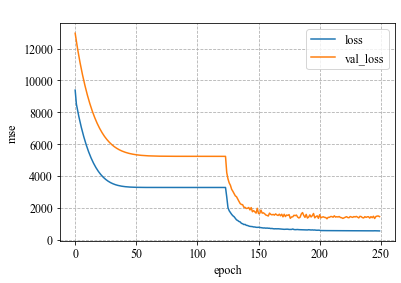

In [107]:
def plotTrainHistory(save_dir,model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(save_dir+'loss.png' ,bbox_inches='tight', dpi=300)  # 600
    plt.show()
    
print(History.history.keys())
plotTrainHistory(save_dir,History)

In [30]:
DCNN_model.load_weights(os.path.join(save_dir, 'model_Weights_best.h5'))

### 方法一：模型 与 权重分开读取

In [31]:
# ###模型保存2
# dir_P,json_P,weights_P = Model_to_save(model, Bpath="CNN_LSTM_Best_Weights/",
#                                       json_path="Functonal_151_j",
#                                       weights_path="model_Weights_last_only")

# ###模型读取
# # reloaded_model = Model_Load(dir_P,json_P,weights_P)

# reloaded_model = Model_Load(dirs =save_dir,
#                             json_path="Functonal_151_j",
#                             weights_path="model_Weights_best_only")

In [98]:
scores = DCNN_model.evaluate(x_train, y_train, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])

34/34 [==============================] - 0s 8ms/step - loss: 796.8962 - mse: 796.8962 - mae: 17.6865 - RMSE: 25.2568 - Scoring_2008: 1123538.8750 - lr: 1.0000e-04


In [99]:
scores = DCNN_model.evaluate(x_test,y_test, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])

1/1 [==============================] - 0s 997us/step - loss: 452.4132 - mse: 452.4132 - mae: 14.3714 - RMSE: 21.2700 - Scoring_2008: 7711.5825 - lr: 1.0000e-04


### 进行预测

In [100]:
y_pred_test = DCNN_model.predict(x_test,verbose=2)
y_true_test = y_test.reshape(y_test.shape[0],1).astype(np.float32)

4/4 - 0s


In [101]:
"""保存预测的RUL值与实际的RUL值"""
y_pred_test=y_pred_test.reshape(y_pred_test.shape[0]*y_pred_test.shape[1]).astype(np.float32)
y_true_test=y_true_test.reshape(y_true_test.shape[0]*y_true_test.shape[1]).astype(np.float32)
y_All=pd.DataFrame({'Pre':y_pred_test,
                   'Actual':y_true_test})
y_All.to_csv(save_dir+"y_lastpoint_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

'保存预测的RUL值与实际的RUL值'

'测试集所有unitNumber的最后一个值进行可视化'

Text(0.5, 1.0, 'FD001, MSE: 452.41, Score2008: 7711.58')

Text(0, 0.5, 'RUL')

Text(0.5, 0, 'Unit Number')

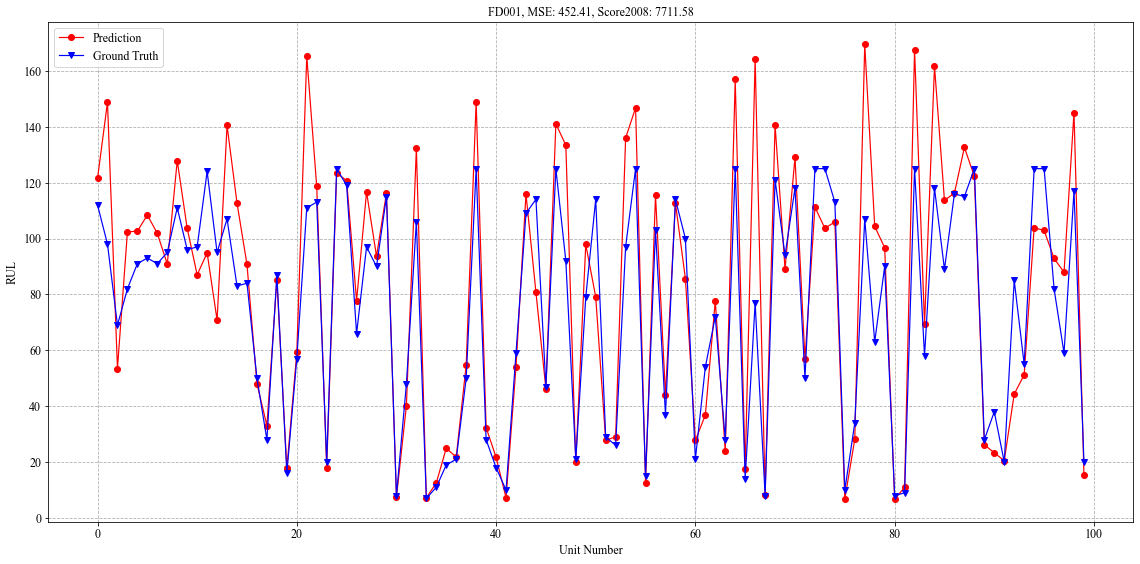

In [102]:
"""测试集所有unitNumber的最后一个值进行可视化"""
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true_test,y_pred_test)
score_2008 = Scoring_2008(y_true_test,y_pred_test)

fig=plt.figure(figsize=(16,8))
plt.grid(linestyle="--")
plt.plot(y_pred_test, color='red', label='Prediction', marker='o',linestyle='-',linewidth=1.2)
plt.plot(y_true_test, color='blue', label='Ground Truth', marker='v',linestyle='-',linewidth=1.2)
plt.title('FD001'+ ', MSE: '+str('%.2f' % mse)+ ', Score2008: '+str('%.2f' % score_2008),fontsize=12)
plt.ylabel('RUL',fontsize=12)
plt.xlabel('Unit Number' ,fontsize=12)
plt.legend(loc='upper left',fontsize=12)
fig.tight_layout()
plt.savefig(save_dir+'FD001_Last_point_Pre.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()